# Logistic Regression Laplace Approximation

In [79]:
# Prior
import torch
import matplotlib.pyplot as plt

prior_mean = torch.tensor([0.0, 0.0])
prior_cov = torch.tensor([[1.,0.],[0.,1.]])

def multivariate_normal(prior_mean, prior_cov):
    return torch.distributions.MultivariateNormal(prior_mean, prior_cov)
prior = multivariate_normal(prior_mean, prior_cov)


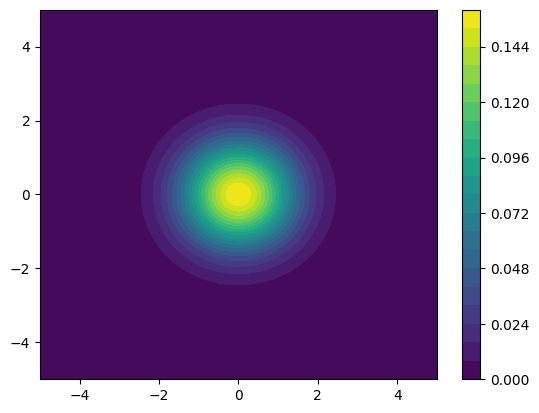

In [102]:
# Plot contour plot of the distribution
def plot_contour_dist(dist, colour=None, alpha=None, linestyle=None, x=None, y=None, title=None):
    if x is None:
        x = torch.linspace(-5, 5, 1000)
    if y is None:
        y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    Z = torch.stack([X, Y], dim=-1)
    z = dist.log_prob(Z).exp()
    z = z.detach().numpy()
    if colour is None:
        colour = 'viridis'
    if alpha is None:
        alpha = 1
    if linestyle is None:
        linestyle = 'solid'
    plt.contourf(X, Y, z , levels = 20, cmap = colour, alpha = alpha, linestyles = linestyle)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()

plot_contour_dist(prior)


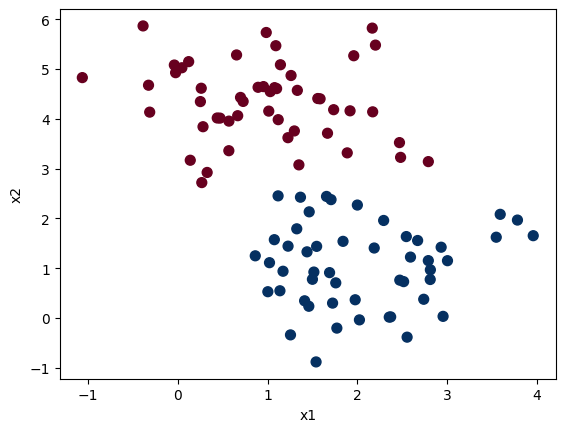

In [81]:
# Create a dataset of 5 points for a classification problem to be solved by logistic regression

import numpy as np
from sklearn.datasets import make_blobs

n_samples = 100
# Generate dataset

def generate_classification_dataset(n_samples=100):
    X, y = make_blobs(
        n_samples=n_samples, centers=2, n_features=2, random_state=0, cluster_std=0.8
    )
    return X, y

# Visualise dataset

def plot_classification_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

X, y = generate_classification_dataset(n_samples)
plot_classification_dataset(X, y)

In [82]:
X = X.astype(np.float32)

In [83]:
torch.tensor(y)
y = y.astype(float)

In [84]:
# likelihood

def forward(X, theta):
    X = torch.tensor(X)
    return torch.sigmoid(X @ theta)
    # return torch.sigmoid(X*theta[1] + theta[0])

def log_likelihood(theta, X=X, y=y):
    p = forward(X, theta)
    dist = torch.distributions.Bernoulli(probs=p)
    return dist.log_prob(torch.tensor(y)).sum()

In [85]:
def log_posterior(theta, prior, X=X, y=y):
    return log_likelihood(theta, X, y) + prior.log_prob(theta)

In [86]:
# Calculate theta map

def map(prior, X=X, y=y):
    theta_map = torch.tensor([0.,0.], requires_grad=True)
    optimizer = torch.optim.Adam([theta_map], lr=0.1)
    for i in range(1000):
        optimizer.zero_grad()
        loss = -log_posterior(theta_map, prior, X, y)
        loss.backward()
        optimizer.step()
    return theta_map

theta_map = map(prior)
print('theta_map:', theta_map)

theta_map: tensor([ 2.1446, -1.4278], requires_grad=True)


/var/folders/nf/tcn1v_gx4pvc23db1_jd0_zr0000gq/T/ipykernel_41665/120313189.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


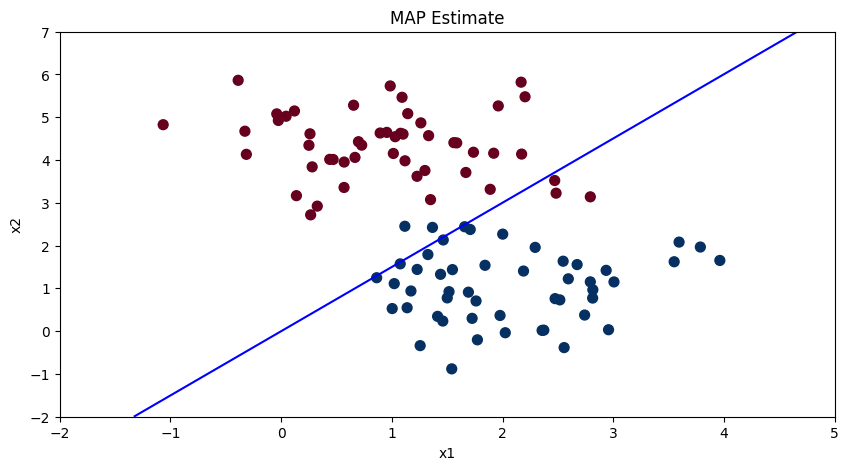

In [87]:
# get the decision boundary line from the map estimate
import matplotlib.patches as mpatches

def plot_map_estimate_decision_boundary(theta_map, X=X, y=y):

    fig = plt.figure(figsize=(10, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="RdBu")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('MAP Estimate')
    x1 = torch.linspace(-2, 5, 1000)
    x2 = torch.linspace(-2, 7, 1000)
    X1, X2 = torch.meshgrid(x1, x2)
    Z = torch.stack([X1, X2], dim=-1)
    z_map = forward(Z, theta_map).detach().numpy()
    plt.contour(X1, X2, z_map, levels=[0.5], colors='blue')
    plt.show()

plot_map_estimate_decision_boundary(theta_map)

In [88]:
def hessian_bivariate_normal(nll, mode):
    hessian = torch.autograd.functional.hessian(nll, mode)
    return torch.inverse(hessian)

nll = lambda theta: -log_likelihood(theta, X, y)
# nll(theta_map)
hessian_bivariate_normal(nll, theta_map)
# posterior_approx_cov = torch.inverse(hessian_bivariate_normal(nll, theta_map))
# posterior_approx_cov

tensor([[ 0.2203, -0.1250],
        [-0.1250,  0.0937]])

In [104]:
def laplace_approx_bivariate_normal(mode):
    nll = lambda theta: -log_likelihood(theta)
    scale = hessian_bivariate_normal(nll, mode)
    # print("The scale in laplace_approx_bivariate_normal is ",scale)
    # print("The mode in laplace_approx_bivariate_normal is ",mode)
    # print("The scale in laplace_approx_bivariate_normal is ",scale)
    laplace_dist = torch.distributions.MultivariateNormal(mode, covariance_matrix=scale)
    return laplace_dist

def plot_bivariate_normal_laplace(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22):
    prior_mean = torch.tensor([prior_mean1, prior_mean2])
    prior_cov = torch.tensor([[prior_cov11, prior_cov12], [prior_cov12, prior_cov22]])
    dist = torch.distributions.MultivariateNormal(prior_mean, prior_cov)
    # params_init = torch.tensor([0.0, 0.0], requires_grad=True)
    params_mode = map(dist)
    print(params_mode)
    laplace_dist = laplace_approx_bivariate_normal(params_mode)
    plot_contour_dist(dist, colour='Reds', title='Prior')
    plot_contour_dist(laplace_dist, colour='plasma', linestyle='--', title='Laplace Approximation')
    plt.show()

In [105]:
from ipywidgets import interact

interact(plot_bivariate_normal_laplace, prior_mean1=(-5,5,0.1), prior_mean2=(-5,5,0.1), prior_cov11=(0.1,5,0.1), prior_cov12=(-5,5,0.1), prior_cov22=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='prior_mean1', max=5.0, min=-5.0), FloatSlider(value=…

<function __main__.plot_bivariate_normal_laplace(prior_mean1, prior_mean2, prior_cov11, prior_cov12, prior_cov22)>

In [ ]:
# approximate the denominator of posterior using monte carlo sampling

def monte_carlo_posterior_denominator(theta, prior, X=X, y=y):